## **Mount Google Drive to store files & data**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **1) Importing Python Packages for GAN**


In [2]:
# from keras.datasets import cifar10, mnist
from keras.models import Sequential
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D, Dense, Conv2DTranspose
from keras.layers import Dropout
from keras.layers.advanced_activations import LeakyReLU
from tensorflow.keras.optimizers import Adam
import numpy as np
!mkdir generated_images resized_images

In [ ]:
##!unzip the-zip-file -d name-of-destination-folder


In [8]:
images_path = "/content/drive/MyDrive/bobross2/"

## **Resizing Data to match Neural Network Input**

In [6]:

import os
# from PIL import Image
import cv2
reshape_size = (64,64)

i = 0
for image in os.listdir(images_path):
  # print(image)
  img = cv2.imread(images_path + image)
  img = cv2.resize(img, reshape_size)
  cv2.imwrite("resized_images/%d.png" % i,img)
  # # print(img.shape)
  i = i+1


## **2) Parameters for Neural Networks & Data**

In [9]:
img_width = 64
img_height = 64
channels = 3
img_shape = (img_width, img_height, channels)
latent_dim = 100
adam = Adam(lr=0.0002)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


## **3) Building Generator**





In [10]:
def build_generator():
    model = Sequential()
    model.add(Dense(256 * 8* 8, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((8,8,256)))

    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
  
    model.summary()

    return model

generator = build_generator()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16384)             1654784   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16384)             0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 128)      524416    
 nspose)                                                         
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 128)      262272    
 ranspose)                                              

## **4) Building Discriminator**

In [11]:
def build_discriminator():
    model = Sequential()
    model.add(Conv2D(64, (3,3), padding='same', input_shape=img_shape))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2D(128, (3,3), padding='same', ))
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Conv2D(128, (3,3), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2D(256, (3,3), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))

    model.summary()
    return model

discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        1792      
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 64, 64, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 64, 64, 128)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 128)       147584    
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 64, 64, 128)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 256)      

## **5) Connecting Neural Networks to build GAN**

In [12]:
GAN = Sequential()
discriminator.trainable = False
GAN.add(generator)
GAN.add(discriminator)

GAN.compile(loss='binary_crossentropy', optimizer=adam)

In [ ]:
# generator.summary()
# discriminator.summary()

## **6) Outputting Images**


In [13]:
#@title
## **7) Outputting Images**
import matplotlib.pyplot as plt
import glob
import imageio
import PIL

save_name = 0.00000000

def save_imgs(epoch):
    r, c = 4, 4
    noise = np.random.normal(0, 1, (r * c, latent_dim))
    gen_imgs = generator.predict(noise)
    global save_name
    save_name += 0.00000001

    # Rescale images 0 - 1
    gen_imgs = (gen_imgs + 1) / 2.0

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt])
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig("currentgeneration.png")
    fig.savefig("generated_images/%.8f.png" % save_name)
    plt.close()

## **7) Training GAN**

In [14]:
from PIL import Image

def train(epochs, batch_size=32, save_interval=200):

  array = []
  #PUT PATH OF RESIZED IMAGES
  path = "/content/resized_images/"

  for dir in os.listdir(path):
            # print(dir)
    image = Image.open(path + dir)
    data = np.asarray(image)
    array.append(data)

  X_train = np.array(array)
  print(X_train.shape)

  # print(X_train.shape)
  #Rescale data between -1 and 1
  X_train = X_train / 127.5 -1.
  bat_per_epo = int(X_train.shape[0] / batch_size)
  # X_train = np.expand_dims(X_train, axis=3)
  print(X_train.shape)

  #Create our Y for our Neural Networks
  valid = np.ones((batch_size, 1))
  fakes = np.zeros((batch_size, 1))

  for epoch in range(epochs):
    for j in range(bat_per_epo):
      #Get Random Batch
      idx = np.random.randint(0, X_train.shape[0], batch_size)
      imgs = X_train[idx]

      #Generate Fake Images
      noise = np.random.normal(0, 1, (batch_size, latent_dim))
      gen_imgs = generator.predict(noise)

      #Train discriminator
      d_loss_real = discriminator.train_on_batch(imgs, valid)
      d_loss_fake = discriminator.train_on_batch(gen_imgs, fakes)
      d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

      noise = np.random.normal(0, 1, (batch_size, latent_dim))
      
      #inverse y label
      g_loss = GAN.train_on_batch(noise, valid)

      print("******* %d %d [D loss: %f, acc: %.2f%%] [G loss: %f]" % (epoch,j, d_loss[0], 100* d_loss[1], g_loss))

      # if(epoch % save_interval) == 0:
    save_imgs(epoch)


train(30000, batch_size=64, save_interval=200)

******* 230 57 [D loss: 0.007651, acc: 100.00%] [G loss: 6.923769]
******* 230 58 [D loss: 0.017156, acc: 99.22%] [G loss: 7.407611]
******* 230 59 [D loss: 0.044925, acc: 98.44%] [G loss: 7.034067]
******* 230 60 [D loss: 0.030021, acc: 99.22%] [G loss: 6.921338]
******* 230 61 [D loss: 0.029828, acc: 99.22%] [G loss: 5.959670]
******* 230 62 [D loss: 0.043935, acc: 98.44%] [G loss: 6.882044]
******* 230 63 [D loss: 0.011887, acc: 100.00%] [G loss: 6.658114]
******* 230 64 [D loss: 0.013414, acc: 99.22%] [G loss: 7.888267]
******* 230 65 [D loss: 0.082662, acc: 96.88%] [G loss: 7.090540]
******* 230 66 [D loss: 0.022279, acc: 99.22%] [G loss: 7.111960]
******* 230 67 [D loss: 0.023670, acc: 100.00%] [G loss: 7.429543]
******* 230 68 [D loss: 0.024335, acc: 99.22%] [G loss: 6.663246]
******* 230 69 [D loss: 0.067282, acc: 97.66%] [G loss: 6.584260]
******* 230 70 [D loss: 0.031461, acc: 99.22%] [G loss: 8.051188]
******* 230 71 [D loss: 0.015886, acc: 99.22%] [G loss: 9.049304]
*******

KeyboardInterrupt: ignored

In [122]:
noise = np.random.normal(0, 1, (234, latent_dim))
gen_imgs = generator.predict(noise)
gen_imgs = (gen_imgs + 1) / 2.0
# plt.imshow(gen_imgs[2])

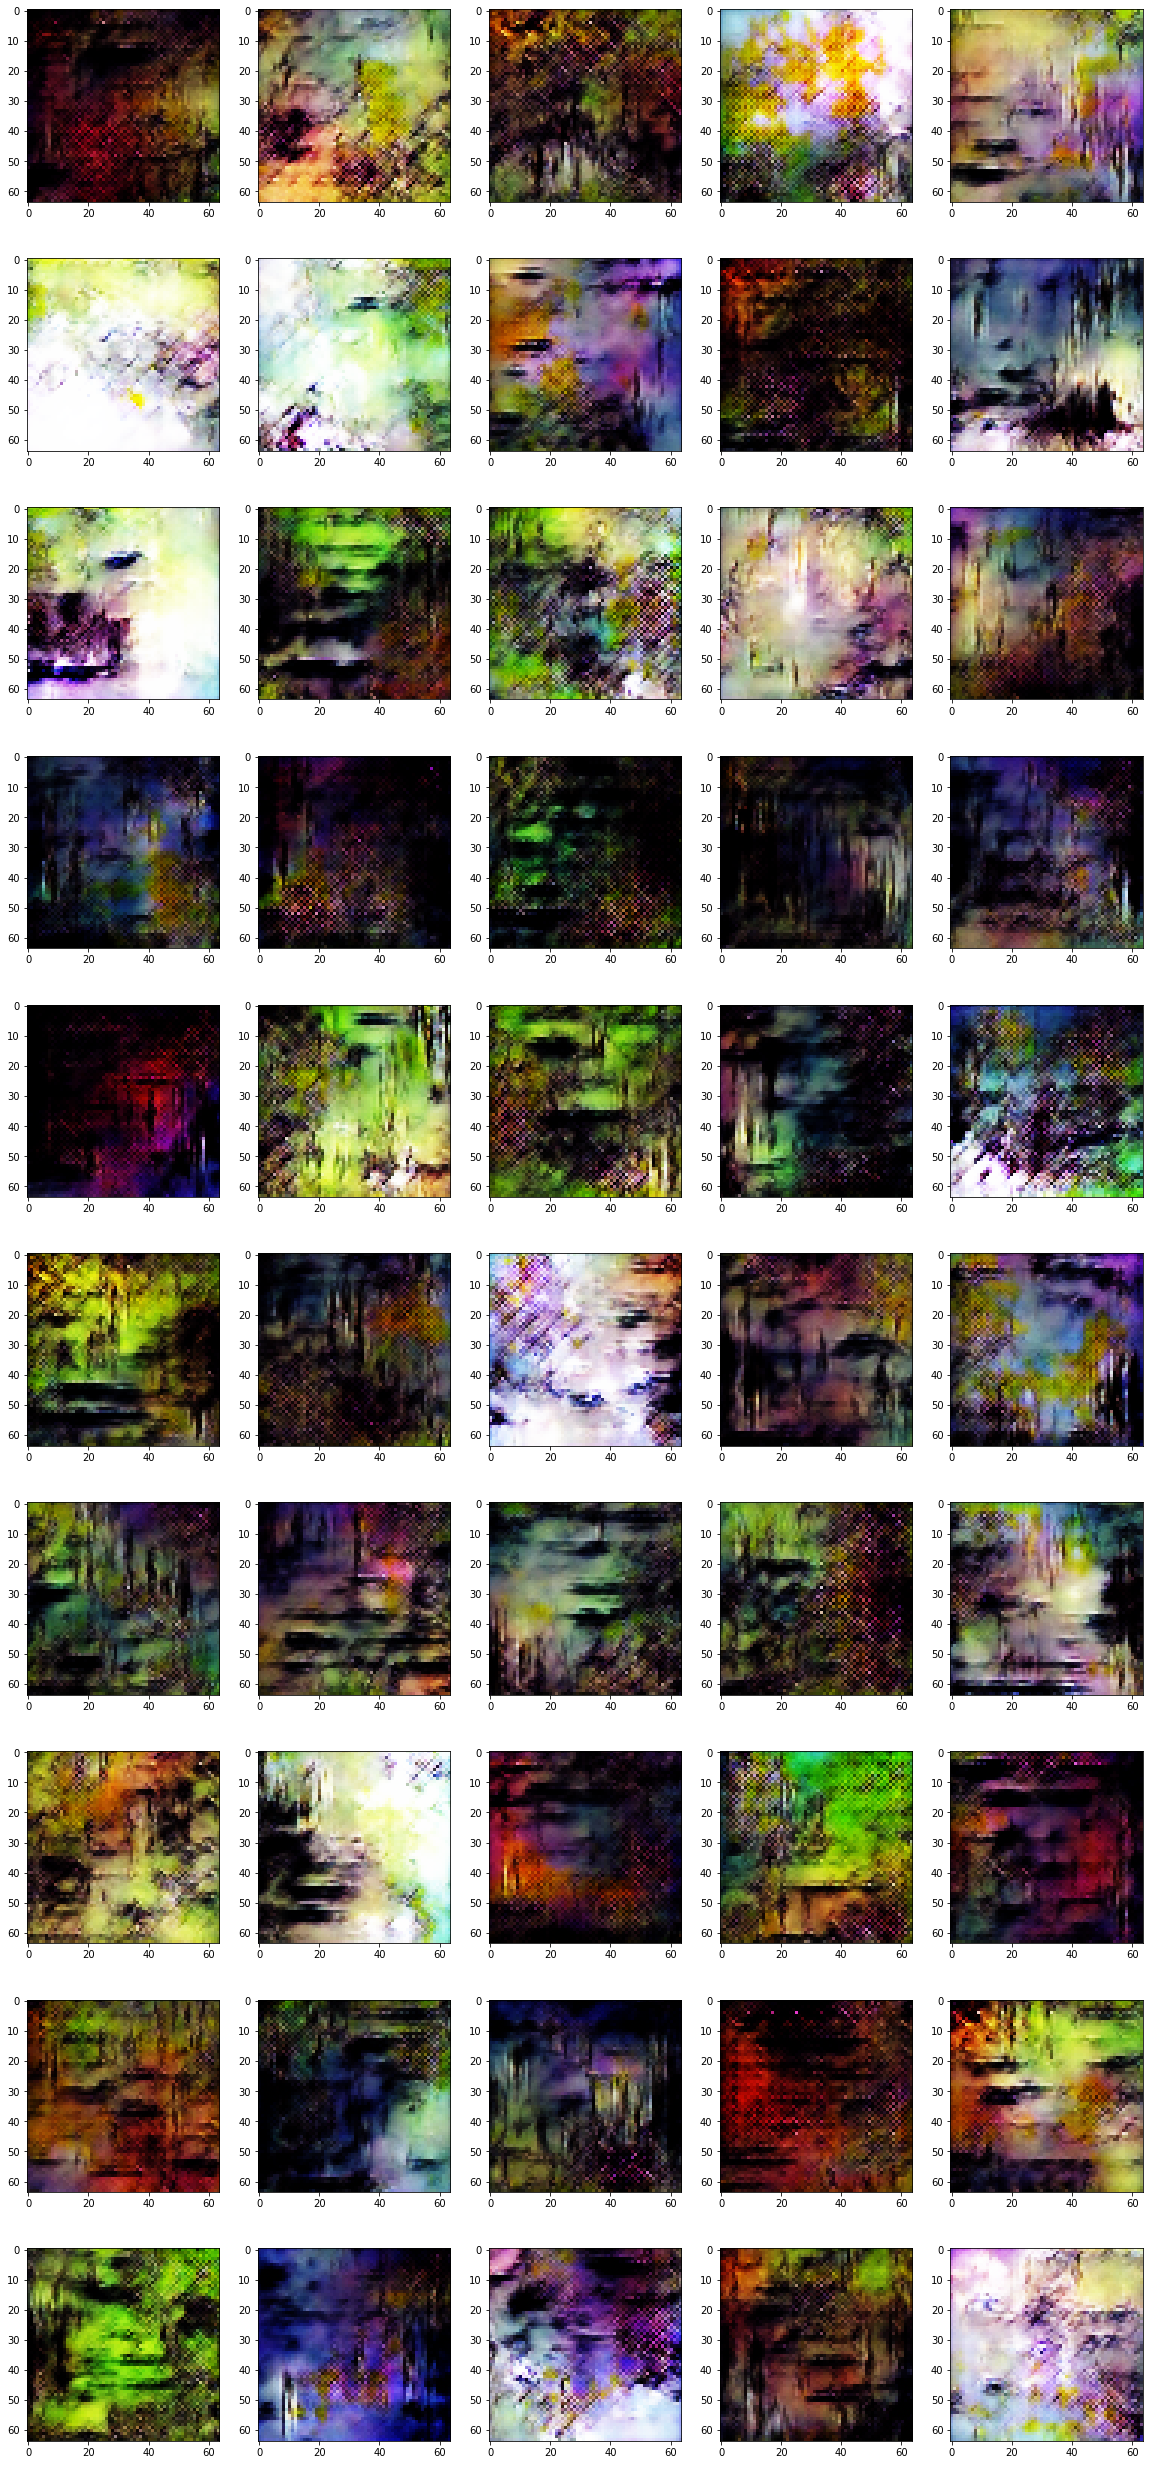

In [134]:
plt.figure(figsize=(20,45),facecolor='white')
plotnum=1
for i in range(0,233):
    if plotnum<=50:
        plt.subplot(10,5,plotnum)
        plt.imshow(gen_imgs[i])
        
    plotnum+=1
plt.show()

In [53]:
generator.save_weights("/content/drive/MyDrive/generator1hour.h5")
discriminator.save_weights("/content/drive/MyDrive/discriminator1hour.h5")

### **8) Making GIF**

In [104]:
 #Display a single image using the epoch number
 def display_image(epoch_no):
   return PIL.Image.open('generated_images/%.8f.png'.format(epoch_no))

anim_file = 'paintgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('generated_images/*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)